# Grad-Cam Results

In [1]:
%pip install pandas torch pytorch-lightning==1.8.6 lightning-lite torchvision scikit-learn matplotlib seaborn opencv-python wilds


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import cv2
from wilds import get_dataset
from torchvision.transforms import ToTensor, Normalize, Compose, CenterCrop, Resize
from torchvision.models import vgg16
from utils.datasets import BinaryDataset

/home/htc/kchitranshi/learning-from-adversarial-perturbations/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
class VGGWithGradCAM(torch.nn.Module):
    def __init__(self, model):
        super(VGGWithGradCAM, self).__init__()
        
        # get the pretrained VGG19 network
        self.vgg = model
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:30]
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

heatmaps/WaterBirds_Original_Waterbird.jpg
Predicted label: -0.64, True label: 1


/tmp/ipykernel_39669/406962495.py:46: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  heatmap = np.maximum(heatmap, 0)


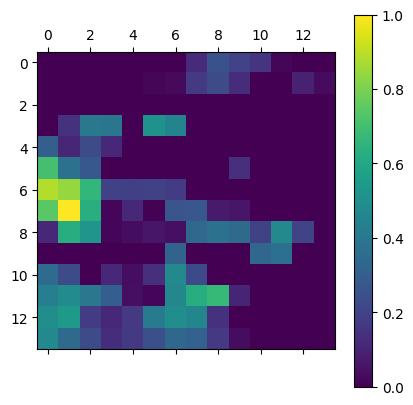

In [9]:

if __name__ == "__main__":
    transform = Compose([
        Resize((224,224)),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    main_dataset = get_dataset(dataset="waterbirds", download=False,root_dir='../SCRATCH/')
    data = main_dataset.get_subset("val", transform=transform)
    data = BinaryDataset(data,which_dataset='waterbirds')
    
    data_to_visualize = main_dataset.get_subset("val", transform=None)
    data_loader = torch.utils.data.DataLoader(data, batch_size=1, shuffle=False, num_workers=2)

    norm = "Original"
    state_dict = torch.load(f"./models/waterbirds_clean_73fb1786-993c-4fff-8552-988db4db2982.pt", map_location='cpu', weights_only=False)
    state_dict = OrderedDict((k.replace('model.model.', '', 1), v) for k, v in state_dict.items())
    
    vgg16_model = vgg16().cuda()
    vgg16_model.classifier[6] = nn.Linear(vgg16_model.classifier[6].in_features,1)
    
    vgg16_model.load_state_dict(state_dict)
    model = VGGWithGradCAM(vgg16_model).cuda()
    model.zero_grad()
    model.eval()

    sample_idx = 345
    iter_dataloader = iter(data_loader)
    for i in range(sample_idx + 1):
        img, target = next(iter_dataloader)

    Class = 'Landbird' if target.float() == -1 else 'Waterbird' 
    model.zero_grad()
    pred = model(img.cuda())
    predi = pred * target.cuda()
    predi.backward()

    gradients = model.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = model.get_activations(img.cuda()).detach()

    for i in range(activations.size(1)):
        activations[:, i, :, :] *= pooled_gradients[i]
    
    heatmap = torch.mean(activations.cpu(), dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    
    plt.matshow(heatmap.squeeze())
    plt.colorbar()
    
    raw_image = data_to_visualize[sample_idx][0]
    #raw_image_tensor = torchvision.transforms.ToPILImage()(raw_image_tensor)
    raw_image.save(f'results/GradCAM/WaterBirds/WaterBirds_Original_{Class}.jpg')
    
    img = cv2.imread(f'results/GradCAM/WaterBirds/WaterBirds_Original_{Class}.jpg')
    heatmap = cv2.resize(heatmap.numpy(), (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    cv2.imwrite(f'results/GradCAM/WaterBirds/WaterBirds_{norm}_{Class}_heatmap.jpg', superimposed_img)

    predicted_label = 1 if pred.item() > 0 else -1
    print(f'heatmaps/WaterBirds_Original_{Class}.jpg')
    print(f"Predicted label: {pred.item():.2f}, True label: {target.item()}")